## Lab 1

### Part 2: Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [ ]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

! pip  install subword-nmt
! pip install nltk
! pip install torchtext

In [ ]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github. Loading special files as well")
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/advanced_f20/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github. Loading special files as well
File ‘data.txt’ already there; not retrieving.



### Warning! The code below is deeeeeeeply deprecated and is is provided only as simple guide.
We suggest you to stick to most recent pipelines here, e.g. by Huggingface: 
* Example notebook: [link](https://github.com/huggingface/notebooks/blob/main/examples/translation.ipynb)
* Converting your own dataset to specific format: [link](https://discuss.huggingface.co/t/correct-way-to-create-a-dataset-from-a-csv-file/15686/15)

In [ ]:
# old deprecated code

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
plt.style.use('ggplot')

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [ ]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [ ]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = torchtext.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [ ]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [ ]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [ ]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [ ]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9282
Unique tokens in target (en) vocabulary: 6734


Here are tokens from original (RU) corpus:

In [ ]:
SRC.vocab.itos[::1000]

['<unk>',
 'еду',
 'базилика',
 'котор',
 'cala',
 'чистый',
 'mia',
 'фриули',
 'доберутся',
 'странд']

And from target (EN) corpus:

In [ ]:
TRG.vocab.itos[::1000]

['<unk>', 'tastefully', 'gdansk', 'calm', 'nevskiy', 'sunway', 'massira']

And here is example from train dataset:

In [ ]:
print(vars(train_data.examples[9]))

{'trg': ['maastricht', '-', 'aachen', 'airport', 'is', '13', '.', '1', 'km', 'away', 'and', 'the', 'property', 'offers', 'free', 'parking', '.'], 'src': ['расстояние', 'до', 'аэропорта', 'маастрихт', '-', 'аахен', 'составляет', '13', ',', '1', 'км', '.', 'гостям', 'предоставляется', 'бесплатная', 'парковка', '.']}


Let's check the length distributions:

Length distribution in Train data


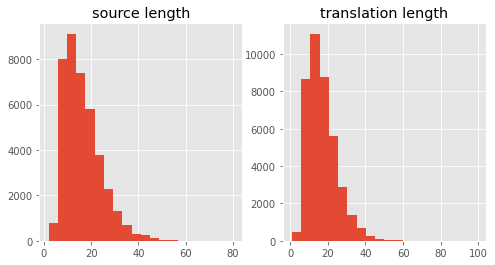

In [ ]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


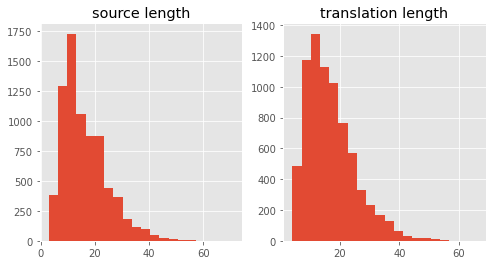

In [ ]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [ ]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 49x128 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 47x128 (GPU 0)]
torch.Size([47, 128]) torch.Size([49, 128])


#### Simple Encoder-Decoder network

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(
            num_embeddings=input_dim,
            embedding_dim=emb_dim
        )

        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout
        )

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, src):
        # src = [src sent len, batch size]

        # Compute an embedding from the src data and apply dropout to it
        # embedded = [src sent len, batch size, emb_dim]
        embedded = self.embedding(src)
        embedded = self.dropout(embedded)

        # Compute the RNN output values of the encoder RNN.
        # outputs, hidden and cell should be initialized here. Refer to nn.LSTM docs ;)
        # outputs = [src sent len, batch size, hid dim * n directions]
        # hidden = [n layers * n directions, batch size, hid dim]
        # cell = [n layers * n directions, batch size, hid dim]
        # outputs are always from the top hidden layer
        output, (hidden, cell) = self.rnn(embedded)
        return output, hidden, cell


class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout_p):
        super().__init__()

        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.dropout_p = dropout_p

        self.embedding = nn.Embedding(
            num_embeddings=output_dim,
            embedding_dim=emb_dim
        )

        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout_p
        )

        self.out = nn.Linear(
            in_features=hid_dim,
            out_features=output_dim
        )

        self.dropout = nn.Dropout(p=dropout_p)

    def forward(self, input, hidden, cell):
        # input = [batch size]
        # hidden = [n layers * n directions, batch size, hid dim]
        # cell = [n layers * n directions, batch size, hid dim]

        # n directions in the decoder will both always be 1, therefore:
        # hidden = [n layers, batch size, hid dim]
        # context = [n layers, batch size, hid dim]
        # input = [1, batch size]
        input = input.unsqueeze(0)

        # Compute an embedding from the input data and apply dropout to it
        # embedded = [1, batch size, emb dim]
        embedded = self.dropout(self.embedding(input))

        # Compute the RNN output values of the encoder RNN.
        # outputs, hidden and cell should be initialized here. Refer to nn.LSTM docs ;)

        # output = [sent len, batch size, hid dim * n directions]
        # hidden = [n layers * n directions, batch size, hid dim]
        # cell = [n layers * n directions, batch size, hid dim]

        # sent len and n directions will always be 1 in the decoder, therefore:
        # output = [1, batch size, hid dim]
        # hidden = [n layers, batch size, hid dim]
        # cell = [n layers, batch size, hid dim]
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))

        # prediction = [batch size, output dim]
        prediction = self.out(output.squeeze(0))
        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"

    def forward(self, src, tgt, teacher_forcing_ratio=0.5):
        # src = [src sent len, batch size]
        # tgt = [tgt sent len, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time

        # Again, now batch is the first dimension instead of zero
        batch_size = tgt.shape[1]
        max_len = tgt.shape[0]
        tgt_vocab_size = self.decoder.output_dim

        # tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, tgt_vocab_size).to(self.device)

        # last hidden state of the encoder is used as the initial hidden state of the decoder
        _, hidden, cell = self.encoder(src)

        # first input to the decoder is the <sos> tokens
        input = tgt[0, :]

        for t in range(1, max_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            input = (tgt[t] if teacher_force else top1)

        return outputs

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9282, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6734, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6734, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,911,054 trainable parameters


In [ ]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)
lr_scheduler = StepLR(optimizer=optimizer, step_size=3, gamma=0.5)

In [ ]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
# train_history = []
# valid_history = []

N_EPOCHS = 10
CLIP = 1

# best_valid_loss = float('inf')
# move to func here

In [ ]:
def train_model(model, train_iterator, valid_iterator, optimizer, criterion,
                lr_scheduler, n_epochs, clip, model_name="model.pth"):
    
    train_history = []
    valid_history = []
    best_valid_loss = float('inf')

    for epoch in range(n_epochs):
        
        start_time = time.time()
        
        train_loss = train(model, train_iterator, optimizer, criterion, clip, train_history, valid_history)
        valid_loss = evaluate(model, valid_iterator, criterion)

        lr_scheduler.step(valid_loss)
        
        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), model_name)
        
        train_history.append(train_loss)
        valid_history.append(valid_loss)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

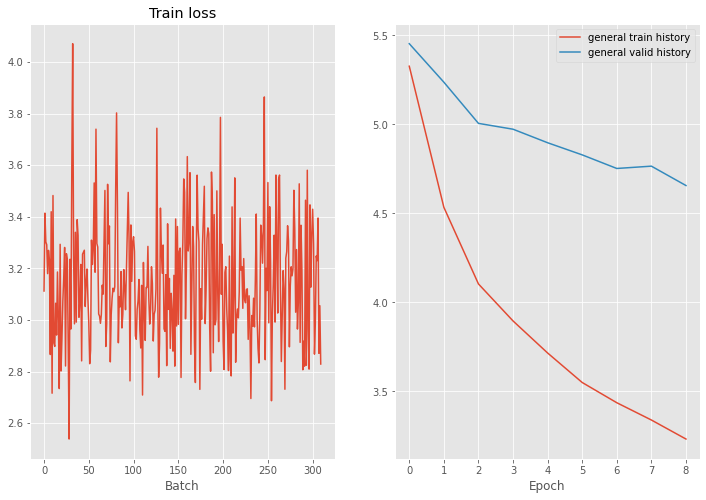

Epoch: 10 | Time: 1m 21s
	Train Loss: 3.147 | Train PPL:  23.261
	 Val. Loss: 4.670 |  Val. PPL: 106.649


In [ ]:
train_model(model, train_iterator, valid_iterator, 
            optimizer, criterion, lr_scheduler, 
            n_epochs=N_EPOCHS, clip=CLIP, model_name="model.pt")

__Let's take a look at our network quality__:

In [ ]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [ ]:
batch = next(iter(test_iterator))

In [ ]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: free wifi access is available .
Generated: free wifi access is available .

Original: bed linen is featured .
Generated: some rooms have a shared .



In [ ]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [ ]:
import tqdm

In [ ]:
'''
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

move to func
'''

In [ ]:
def get_generated_texts(model, test_iterator):
    original_text = []
    generated_text = []
    model.eval()
    with torch.no_grad():

        for i, batch in tqdm.tqdm(enumerate(test_iterator)):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output.argmax(dim=-1)
            
            original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
            generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

    return original_text, generated_text

In [ ]:
orig_text_Seq2Seq, gen_text_Seq2Seq = get_generated_texts(model, test_iterator)

59it [00:03, 17.95it/s]


In [ ]:
corpus_bleu([[text] for text in orig_text_Seq2Seq], gen_text_Seq2Seq) * 100

13.569694777693488

Baseline solution BLEU score is quite low. Try to achieve at least __21__ BLEU on the test set. 
The checkpoints are:

* __21__ - minimal score to submit the homework, 30% of points

* __25__ - good score, 70% of points

* __27__ - excellent score, 100% of points

#### Transformer

In [ ]:
# Implementation of Transformer architecture using nn.Transformer class
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.scale = nn.Parameter(torch.ones(1))

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, src):
        src = src + self.scale * self.pe[:src.size(0), :]
        return self.dropout(src)

class Seq2SeqTransformer(nn.Module):
    def __init__(self, src_dim, tgt_dim, emb_dim, enc_layers=1, dec_layers=1, n_heads=1, dim_feedforward=2048, dropout=0.1, activation="relu", pad_idx=1, sos_idx=2, device="cuda"):
        super(Seq2SeqTransformer, self).__init__()
        self.src_dim = src_dim
        self.tgt_dim = tgt_dim
        self.emb_dim = emb_dim

        self.enc_emb = nn.Embedding(src_dim, emb_dim)
        self.dec_emb = nn.Embedding(tgt_dim, emb_dim)
        self.pos_encoder = PositionalEncoding(emb_dim, dropout)

        self.transformer_model = nn.Transformer(d_model=emb_dim,nhead=n_heads,num_encoder_layers=enc_layers,num_decoder_layers=dec_layers,dim_feedforward=dim_feedforward,dropout=dropout,activation=activation)
        self.linear = nn.Linear(emb_dim, tgt_dim)

        self.pad_idx = pad_idx
        self.sos_idx = sos_idx
        self.device = device

        self.src_mask = None
        self.tgt_mask = None
        self.memory_mask = None

    def make_len_mask(self, inp):
        return inp == self.pad_idx

    def forward(self, src, tgt, teacher_forcing_ratio=0.5):
        output_len = tgt.shape[0]
        batch_size = tgt.shape[1]
        src = src.transpose(0, 1)
        tgt = tgt.transpose(0, 1)
        src_key_padding_mask = self.make_len_mask(src)

        src = self.pos_encoder((self.enc_emb(src) * math.sqrt(self.emb_dim)).transpose(0, 1))
        encoder_hidden_states = self.transformer_model.encoder(src, src_key_padding_mask=src_key_padding_mask)
        decoder_inputs = torch.empty((src.size(1), output_len + 1), dtype=torch.int64, device=self.device).fill_(self.sos_idx)
        decoder_outputs = torch.zeros(output_len, src.size(1), self.tgt_dim, device=self.device)

        for i in range(output_len):
            decoder_input = (self.dec_emb(decoder_inputs[:, :i + 1]) * math.sqrt(self.emb_dim)).transpose(0, 1)
            decoder_input = self.pos_encoder(decoder_input)

            tgt_mask = self.transformer_model.generate_square_subsequent_mask(i + 1).to(self.device)

            decoder_output = self.transformer_model.decoder(tgt=decoder_input, memory=encoder_hidden_states, tgt_mask=tgt_mask, memory_key_padding_mask=src_key_padding_mask)
            decoder_output = self.linear(decoder_output)[-1]
            decoder_outputs[i] = decoder_output
            decoder_inputs[:, i + 1] = decoder_output.max(1)[1]

        return decoder_outputs

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
NHEAD = 2
ENC_LAYERS = 2
DEC_LAYERS = 2
EMB_DIM = 512
DROPOUT = 0.2

model_transformer = Seq2SeqTransformer(INPUT_DIM, OUTPUT_DIM, EMB_DIM, NHEAD, ENC_LAYERS, DEC_LAYERS).to(device)

In [ ]:
optimizer_transformer = optim.AdamW(model_transformer.parameters())
criterion_transformer = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
lr_scheduler_transformer = ReduceLROnPlateau(optimizer=optimizer_transformer, patience=2, factor=0.2)

In [ ]:
print(f'The model has {count_parameters(model_transformer):,} trainable parameters')

The model has 26,369,615 trainable parameters


In [ ]:
def init_weights_transformer(m):
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

In [ ]:
model_transformer.apply(init_weights_transformer)

Seq2SeqTransformer(
  (enc_emb): Embedding(9282, 512)
  (dec_emb): Embedding(6734, 512)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_model): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
      

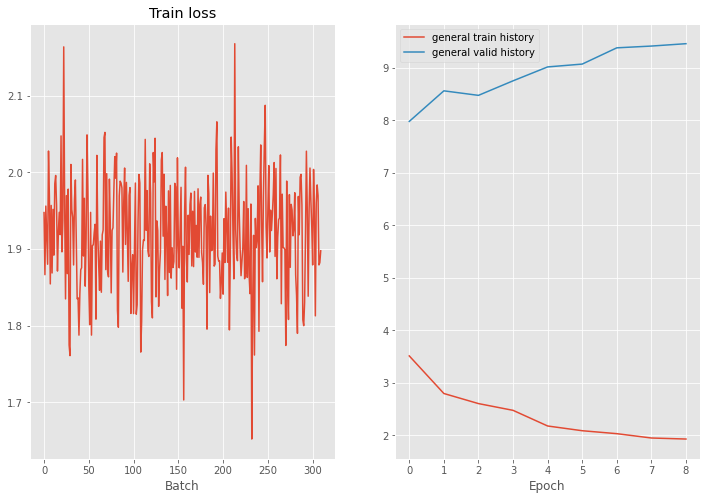

Epoch: 10 | Time: 1m 7s
	Train Loss: 1.919 | Train PPL:   6.817
	 Val. Loss: 9.487 |  Val. PPL: 13193.027


In [ ]:
train_model(model_transformer, train_iterator, valid_iterator, 
            optimizer_transformer, criterion_transformer, 
            lr_scheduler_transformer, n_epochs=N_EPOCHS, clip=CLIP, 
            model_name="model_transformer.pt")

In [ ]:
orig_text_transformer, gen_text_transformer = get_generated_texts(model_transformer, test_iterator)

59it [00:21,  2.73it/s]


In [ ]:
corpus_bleu([[text] for text in orig_text_transformer], gen_text_transformer) * 100

10.717154766941867

Not so great as I was expecting. Actually, even worse than Baseline solution BLEU.

In [ ]:
for idx in [1, 2, 3, 4, 5]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model_transformer, TRG.vocab)

Original: free wifi access is available .
Generated: wi - fi access is available .

Original: bed linen is featured .
Generated: linen is featured .

Original: you will find a 24 - hour front desk at the property .
Generated: is a 24 - hour front desk at the property .

Original: there is a 24 - hour front desk at the property .
Generated: is a 24 - hour front desk at the property .

Original: there is a 24 - hour front desk at the property .
Generated: is a 24 - hour front desk at the property .



#### Attention in Seq2Seq

In [ ]:
# Seq2Seq model with LSTM Encoder - LSTM Decoder with implementation of Attention Mechanism
class Attention(nn.Module):

    def __init__(self, dimensions, attention_type='general'):
        super(Attention, self).__init__()

        if attention_type not in ['dot', 'general']:
            raise ValueError('Invalid attention type selected.')

        self.attention_type = attention_type
        if self.attention_type == 'general':
            self.linear_in = nn.Linear(dimensions, dimensions, bias=False)

        self.linear_out = nn.Linear(dimensions * 2, dimensions, bias=False)
        self.softmax = nn.Softmax(dim=-1)
        self.tanh = nn.Tanh()

    def forward(self, query, context):
        batch_size, output_len, dimensions = query.size()
        query_len = context.size(1)

        if self.attention_type == "general":
            query = query.reshape(batch_size * output_len, dimensions)
            query = self.linear_in(query)
            query = query.reshape(batch_size, output_len, dimensions)

        attention_scores = torch.bmm(query, context.transpose(1, 2).contiguous())

        # Compute weights across every context sequence
        attention_scores = attention_scores.view(batch_size * output_len, query_len)
        attention_weights = self.softmax(attention_scores)
        attention_weights = attention_weights.view(batch_size, output_len, query_len)

        mix = torch.bmm(attention_weights, context)

        combined = torch.cat((mix, query), dim=2)
        combined = combined.view(batch_size * output_len, 2 * dimensions)

        # Apply linear_out on every 2nd dimension of concat
        output = self.linear_out(combined).view(batch_size, output_len, dimensions)
        output = self.tanh(output)

        return output, attention_weights

class DecoderAttention(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout_p=0.5, attention_type="general"):
        super().__init__()

        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.dropout_p = dropout_p

        self.embedding = nn.Embedding(
            num_embeddings=output_dim,
            embedding_dim=emb_dim
        )
        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout_p
        )
        self.attention = Attention(hid_dim, attention_type=attention_type)
        self.out = nn.Linear(
            in_features=hid_dim,
            out_features=output_dim
        )
        self.dropout = nn.Dropout(p=dropout_p)

    def forward(self, input, encoder_context, hidden, cell):
        input = input.unsqueeze(0)

        # Compute an embedding from the input data and apply dropout to it
        # embedded = [1, batch size, emb dim]
        embedded = self.dropout(self.embedding(input))
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        attention_output, _ = self.attention(output.transpose(0, 1), encoder_context.transpose(0, 1))
        attention_output = attention_output.transpose(0, 1)

        # prediction = [batch size, output dim]
        prediction = self.out(attention_output.squeeze(0))
        return prediction, hidden, cell


class Seq2SeqAttention(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        assert isinstance(self.decoder, DecoderAttention), \
            "Decoder must be an instance of DecoderAttention class!"

    def forward(self, src, tgt, teacher_forcing_ratio=0.5):
        batch_size = tgt.shape[1]
        max_len = tgt.shape[0]
        tgt_vocab_size = self.decoder.output_dim

        # tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, tgt_vocab_size).to(self.device)
        # last hidden state of the encoder is used as the initial hidden state of the decoder
        encoder_context, hidden, cell = self.encoder(src)
        # first input to the decoder is the <sos> tokens
        input = tgt[0, :]

        for t in range(1, max_len):
            output, hidden, cell = self.decoder(input, encoder_context, hidden, cell)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            input = (tgt[t] if teacher_force else top1)

        return outputs

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec_attention = DecoderAttention(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model_attention = Seq2SeqAttention(enc, dec_attention, device).to(device)

In [ ]:
model_attention.apply(init_weights)

Seq2SeqAttention(
  (encoder): Encoder(
    (embedding): Embedding(9282, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): DecoderAttention(
    (embedding): Embedding(6734, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (attention): Attention(
      (linear_in): Linear(in_features=512, out_features=512, bias=False)
      (linear_out): Linear(in_features=1024, out_features=512, bias=False)
      (softmax): Softmax(dim=-1)
      (tanh): Tanh()
    )
    (out): Linear(in_features=512, out_features=6734, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
print(f'The model has {count_parameters(model_attention):,} trainable parameters')

The model has 15,697,486 trainable parameters


In [ ]:
optimizer_attention = optim.AdamW(model_attention.parameters())
criterion_attention = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
lr_scheduler_attention = ReduceLROnPlateau(optimizer=optimizer_attention, patience=2, factor=0.2)

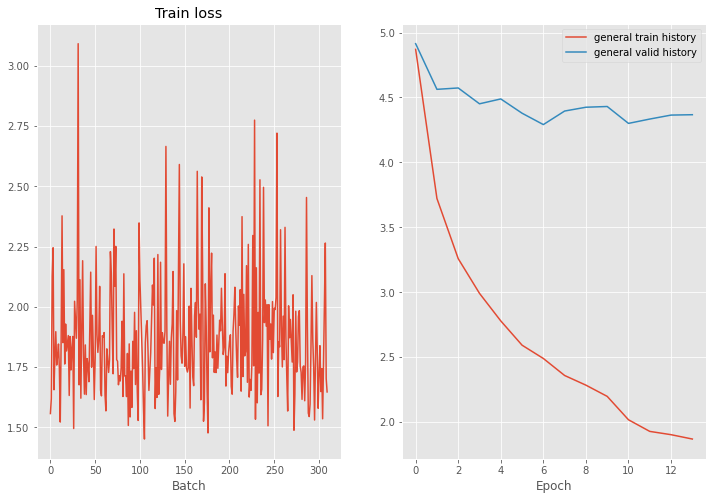

Epoch: 15 | Time: 1m 40s
	Train Loss: 1.867 | Train PPL:   6.467
	 Val. Loss: 4.386 |  Val. PPL:  80.330


In [ ]:
train_model(model_attention, train_iterator, valid_iterator, 
            optimizer_attention, criterion_attention, lr_scheduler_attention, 
            n_epochs=15, clip=CLIP, model_name="model_attention.pt")

In [ ]:
orig_text_attention, gen_text_attention = get_generated_texts(model_attention, test_iterator)

59it [00:04, 14.58it/s]


In [ ]:
corpus_bleu([[text] for text in orig_text_attention], gen_text_attention) * 100

32.48880334013645

Wow!!!! What an amazing result!

In [ ]:
for idx in [1, 2, 3, 4, 5]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model_attention, TRG.vocab)

Original: free wifi access is available .
Generated: free wifi access is available .

Original: bed linen is featured .
Generated: bed linen is featured .

Original: you will find a 24 - hour front desk at the property .
Generated: you will find a 24 - hour front desk .

Original: there is a 24 - hour front desk at the property .
Generated: there is a 24 - hour front desk .

Original: there is a 24 - hour front desk at the property .
Generated: you will find a 24 - hour front desk .

